# Analyzing WeRateDogs data

## Table of Contents
- [Description](#description)
- [First steps](#firststeps)
- [Gather](#gather)
- [Assess](#assess)
- [Clean](#clean)
- [Analyze](#analyze)

<a id='description'></a>
## Description
In the following notebook, I will clean a given dataset complemented with WeLoveDogs twitter data.

<a id='firststeps'></a>
## First Steps
Importing the necessary libraries and files.

In [58]:
import requests
import os

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv'
filename = 'twitter-archive-enhanced.csv'

path = os.getcwd()

def prepare_files(url, filename):
    # Change dir to notebook path
    os.chdir(path)

    # Try to create a data directory
    try:
        os.mkdir('data')
    except FileExistsError:
        pass
    
    # Get the file from the internet
    r = requests.get(url)

    # Write the file into the folder
    with open('data/' + filename, 'wb') as f:
        f.write(r.content)

prepare_files(url, filename)

In [59]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv("data/twitter-archive-enhanced.csv")

<a id='gather'></a>
## Gather

In this part, I will gather all the necessary data to carry the project. There are additional datasets that should be included in this project. I will start with the tweet image predictions file and follow with the Tweepy data that will be stored in a JSON file.

### Tweet Image Predictions


This file is hosted on Udacity's servers and should be downloaded programatically.

In [60]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
filename = 'image-predictions.tsv'

prepare_files(url, filename)

In [61]:
df_img = pd.read_table("data/image-predictions.tsv")

### Tweepy Data

To retrieve this data, I will have to use the Twitter API and store the piles in a JSON file.

In [62]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

With the help of [Richard Chadwick from Towards Data Science](https://towardsdatascience.com/tweepy-for-beginners-24baf21f2c25) and the script provided by Udacity, I have come up with the following code to retrieve all tweets by ID and store its details in a json file.

In [63]:
id_list = df.tweet_id.values

# Retrieve each tweet in "id_list" and store it in "tweet_json.txt". One tweet each line.
def tweet_retriever():
    count = 0
    fails_dict = {}
    start = timer()
    with open("data/tweet_json.txt", "w") as f: 
        for i in id_list:
            count += 1
            print(str(count) + ": " + str(i))
            try:
                tweet = api.get_status(i, tweet_mode='extended')
                json_str = json.dumps(tweet._json)
                f.write(json_str + "\n") 
            except ValueError as e:
                print("Fail")
                fails_dict[i] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)
                    
# Run the function when needed
#tweet_retriever()

The code above has been looking through all the observations in the "tweet_id" column of the main dataframe (df). After building the json file, I will create the dataframe "df_json" out of that json file:

In [64]:
df_json = pd.read_json("data/tweet_json.txt", lines=True)

<a id='assess'></a>
## Assess

Once all the data is gathered, I will procceed to assess the data and do a first visual approach of the data to see what can we clean.

In [65]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [67]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [68]:
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [69]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [70]:
df_img.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [71]:
df_json.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [72]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [73]:
df_json.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,retweet_count,favorite_count,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str
count,2.354000e+03,2.354000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,0.0,0.0,0.0,2354.000000,2354.000000,2211.0,2211.0,2.900000e+01,2.900000e+01
mean,7.426978e+17,7.426978e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,NaN,NaN,NaN,3164.797366,8080.968564,0.0,0.0,8.162686e+17,8.162686e+17
std,6.852812e+16,6.852812e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,NaN,NaN,NaN,5284.770364,11814.771334,0.0,0.0,6.164161e+16,6.164161e+16
min,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,6.721083e+17,6.721083e+17
25%,6.783975e+17,6.783975e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,NaN,NaN,NaN,624.500000,1415.000000,0.0,0.0,7.888183e+17,7.888183e+17
50%,7.194596e+17,7.194596e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,1473.500000,3603.500000,0.0,0.0,8.340867e+17,8.340867e+17
75%,7.993058e+17,7.993058e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,3652.000000,10122.250000,0.0,0.0,8.664587e+17,8.664587e+17
max,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,NaN,NaN,NaN,79515.000000,132810.000000,0.0,0.0,8.860534e+17,8.860534e+17


### Quality
#### `df` table:
- Missing expanded_urls values.
- Missing in_reply_to status_id and in_reply_to user_id values.
- tweet_id, in_reply_to_status_id and in_reply_to_user_id should be strings. Timestamp as date/time.
- Retweets are not useful for this project. Remove them. 

#### `df_json` table:
- Missing values in variables geo, coordinates, place and contributors.
- Missing values in in_reply_to_status_id, in_reply_to_user_id and quote_status_id.
- Retweets are not useful for this project. Remove them.
- Change id variable name to tweet_id.
- in_reply_to_status_id, in_reply_to_user_id and quote_status_id should be formatted as strings.
- id_str, in_reply_to_status_id_str ad in_reply_to_user_id_str and quoted_status_id_str are redundant and should be dropped.
- possibly_sensitive should be a bool value.
- possibly_sensitive_appealable  is a legacy value and should be dropped.

#### `df_img` table:
- Unstandardized data in p1, p2 and p3. The variables are upper and lower case (i.e "miniature_pinscher" and "German_shepherd".
- Character "_" instead of a blank space. 


### Tidiness

- `df_json` table should be part of `df` table.
- Data in doggo, floofer, pupper and puppo is not formatted correctly. Data should be categorical and merged into one column.

<a id='clean'></a>
## Clean

In [74]:
df_clean = df.copy()
df_img_clean = df_img.copy()
df_json_clean = df_json.copy()

## Quality

## `df` 
- Missing expanded_urls values.
- Missing in_reply_to status_id and in_reply_to user_id values.
- tweet_id, in_reply_to_status_id and in_reply_to_user_id should be strings. Timestamp as date/time.
- Retweets are not useful for this project. Remove them. 

#### `df`: Missing values in expanded_urls variable.

#### Define

As the expaned_urls follow an specific pattern based on the twitter profile and the tweet id, I will complete all of the missing ones. This is done by adding the tweet id to "https://twitter.com/dog_rates/status/".

#### Code

In [75]:
#Variable transformation
df_clean["expanded_urls"] = "https://twitter.com/dog_rates/status/" + df_clean["tweet_id"].astype(str)

#### Test

In [76]:
df_clean["expanded_urls"].isnull().sum()

0

#### `df`: Missing in_reply_to status_id and in_reply_to user_id values.

#### Define

A lot of the values are missing for this variables. As it is impossible to fill up with the correct information, I will drop the columns.

#### Code

In [77]:
# Fill missing values
df_clean["in_reply_to_status_id"].fillna(0, inplace=True)
df_clean["in_reply_to_user_id"].fillna(0, inplace=True)

#### Test

In [78]:
(df_clean.in_reply_to_status_id.isnull().sum(), df_clean.in_reply_to_user_id.isnull().sum())

(0, 0)

#### `df`: in_reply_to_status_id and in_reply_to_user_id should be strings

#### Code

In [79]:
# Transform values
df_clean["tweet_id"] = df_clean["tweet_id"].astype(str)
df_clean["in_reply_to_status_id"] = df_clean["in_reply_to_status_id"].astype(str)
df_clean["in_reply_to_user_id"] = df_clean["in_reply_to_user_id"].astype(str)
df_clean["timestamp"] = pd.to_datetime(df_clean["timestamp"])

#### Test

In [80]:
(df_clean.in_reply_to_status_id.dtype, df_clean.in_reply_to_user_id.dtype, df_clean.timestamp.dtype)

(dtype('O'), dtype('O'), datetime64[ns, UTC])

#### `df` and `df_json`: remove retweets.

#### Define

Retweets are not useful for this analysis. I will remove them and then drop the columns.

#### Code

In [81]:
# Remove retweet observations
df_clean = df_clean[df_clean.retweeted_status_id.isnull()]
df_clean = df_clean[df_clean.retweeted_status_user_id.isnull()]
df_clean = df_clean[df_clean.retweeted_status_timestamp.isnull()]
df_json_clean = df_json_clean[df_json_clean.retweeted_status.isnull()]

In [82]:
# Drop retweet variables
df_clean.drop(["retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"], axis=1, inplace=True)
df_json_clean.drop("retweeted_status", axis=1, inplace=True)

#### Test

In [83]:
# df_clean columns
("retweeted_status_id" or "retweeted_status_user_id" or "retweeted_status_timestamp") in df_clean.columns

False

In [84]:
# df_json columns
"retweeted_status" in df_json_clean.columns

False

## `df_json`

- Missing values in variables geo, coordinates, place and contributors.
- Missing values in in_reply_to_status_id, in_reply_to_user_id and quote_status_id.
- Retweets are not useful for this project. Remove them.
- Change id variable name to tweet_id.
- in_reply_to_status_id, in_reply_to_user_id and quote_status_id should be formatted as strings.
- id_str, in_reply_to_status_id_str ad in_reply_to_user_id_str and quoted_status_id_str are redundant and should be dropped.
- possibly_sensitive should be a bool value.
- possibly_sensitive_appealable  is a legacy value and should be dropped.

#### `df_json`: Missing geo, coordinates, place and contributors values.

#### Define

A lot of the values are missing for this variables. As it is impossible to fill up with the correct information, I will drop the columns.

#### Code

In [85]:
df_json_clean.drop(["geo", "coordinates", "place", "contributors"], axis=1, inplace=True)

#### Test

In [86]:
("geo" or "coordinates" or "place" or "contributors") in df_json_clean.columns

False

#### `df_json`: Missing values in in_reply_to_status_id, in_reply_to_user_id and quote_status_id.

#### Code

In [87]:
# Fill missing values
df_json_clean["in_reply_to_status_id"].fillna(0, inplace=True)
df_json_clean["in_reply_to_user_id"].fillna(0, inplace=True)
df_json_clean["quoted_status_id"].fillna(0, inplace=True)
df_json_clean["possibly_sensitive"].fillna(0, inplace=True)

#### Test

In [88]:
(df_json_clean.in_reply_to_status_id.isnull().sum(), 
 df_json_clean.in_reply_to_user_id.isnull().sum(), 
 df_json_clean.quoted_status_id.isnull().sum(),
 df_json_clean.possibly_sensitive.isnull().sum())

(0, 0, 0, 0)

#### `df_json`: rename id variable to match with df table.

#### Define

id variable should be renamed to match with the df table

#### Code

In [89]:
df_json_clean.rename(columns={"id": "tweet_id"}, inplace=True)

#### Test

In [90]:
"tweet_id" in df_json_clean.columns

True

#### `df_json`: tweet_id, in_reply_to_status_id, in_reply_to_user_id and  quoted_status_id should be strings

#### Code

In [91]:
# Change variable type to integer
df_json_clean["tweet_id"] = df_json_clean["tweet_id"].astype(str)
df_json_clean["in_reply_to_status_id"] = df_json_clean["in_reply_to_status_id"].astype(str)
df_json_clean["in_reply_to_user_id"] = df_json_clean["in_reply_to_user_id"].astype(str)
df_json_clean["quoted_status_id"] = df_json_clean["quoted_status_id"].astype(str)
df_json_clean["possibly_sensitive"] = df_json_clean.possibly_sensitive.astype(bool)

#### Test

In [92]:
(df_json_clean.tweet_id.dtype, df_json_clean.in_reply_to_status_id.dtype, df_json_clean.in_reply_to_user_id.dtype, df_json_clean.quoted_status_id.dtype, df_json_clean.possibly_sensitive.dtype )

(dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('bool'))

#### `df_json`: id_str, in_reply_to_status_id_str ad in_reply_to_user_id_str and quoted_status_id_str are redundant and should be dropped.

#### Code

In [93]:
# Change variable type
df_json_clean.drop(["id_str", "in_reply_to_status_id_str", "in_reply_to_user_id_str", "quoted_status_id_str"], axis=1, inplace=True)

#### Test

In [94]:
("id_str" or "in_reply_to_status_id_str" or "in_reply_to_user_id_str" or "quoted_status_id_str") in df_json_clean.columns

False

#### `df_json`: possibly_sensitive_appealable is a legacy value

#### Define

This is a legacy value and should be dropped.

#### Code

In [95]:
df_json_clean.drop("possibly_sensitive_appealable", axis=1, inplace=True)

#### Test

In [96]:
"possibly_sensitive_appealable" in df_json_clean.columns

False

## `df_img`
- Unstandarized data in p1, p2 and p3. The variables are upper and lower case (i.e "miniature_pinscher" and "German_shepherd".
- Character "_" instead of a blank space. 

#### `df_img`: unstandarized data in p1, p2 and p3.

#### Define

The strings in p1, p2 and p3 are not standarized. I will make all of them lowercase and remove the "_" used to separate blank spaces.

#### Code

In [97]:
# Make all strins lower case
df_img_clean["p1"] = df_img_clean.p1.str.lower()
df_img_clean["p2"] = df_img_clean.p2.str.lower()
df_img_clean["p3"] = df_img_clean.p3.str.lower()

In [98]:
# Replace "_" with " "
df_img_clean["p1"] = df_img_clean.p1.str.replace("_", " ")
df_img_clean["p2"] = df_img_clean.p2.str.replace("_", " ")
df_img_clean["p3"] = df_img_clean.p3.str.replace("_", " ")

#### Test

In [99]:
df_img_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,collie,0.156665,True,shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


### Tidiness

- `df_json`table should be part of `df` table.
- Lots of duplicated values in `df_json` table that are already contained in `df` table.

## Tidiness

#### `df`: combine doggo, floofer, pupper and puppo into one variable.

#### Define

It does not make sense to have four different categorical values separated. I will do a column summing all the variables and then change value names. After that, the unnecesary columns will be dropped.

#### Code

In [100]:
# Concatenate columns
df_clean["term"] = df["doggo"] + df["floofer"] + df["pupper"] + df["puppo"]

# Change the values
df_clean["term"].loc[df_clean.term == "doggoflooferNoneNone"] = "doggo, floofer"
df_clean["term"].loc[df_clean.term == "doggoNonepupperNone"] = "doggo, pupper"
df_clean["term"].loc[df_clean.term == "doggoNoneNonepuppo"] = "doggo, puppo"
df_clean["term"].loc[df_clean.term == "doggoNoneNoneNone"] = "doggo"
df_clean["term"].loc[df_clean.term == "NoneflooferNoneNone"] = "floofer"
df_clean["term"].loc[df_clean.term == "NoneNonepupperNone"] = "pupper"
df_clean["term"].loc[df_clean.term == "NoneNoneNonepuppo"] = "puppo"
df_clean["term"].loc[df_clean.term == "NoneNoneNoneNone"] = "None"

# Drop the unnecessary columns
df_clean.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)

C:\Users\andrw\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Test

In [101]:
df_clean.term.value_counts()

None              1831
pupper             224
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: term, dtype: int64

#### `df_json` and `df_img`should be part of df table

#### Define

Three tables are not useful for this dataset. Merging two of them is needed. This two are `df_json` and `df`. I will merge them using "id" as index.

#### Code

In [102]:
df_img_clean["tweet_id"] = df_img_clean["tweet_id"].astype(str)

# Merge the columns
df_clean = pd.merge(df_clean, df_json_clean, on="tweet_id", how="left")
df_clean = pd.merge(df_clean, df_img_clean, on="tweet_id", how="left")

# Drop duplicated data
df_clean.drop(["full_text", "source_y", "in_reply_to_status_id_y", "in_reply_to_user_id_y", "created_at"], axis=1, inplace=True)

#### Test

In [103]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   tweet_id                 2175 non-null   object             
 1   in_reply_to_status_id_x  2175 non-null   object             
 2   in_reply_to_user_id_x    2175 non-null   object             
 3   timestamp                2175 non-null   datetime64[ns, UTC]
 4   source_x                 2175 non-null   object             
 5   text                     2175 non-null   object             
 6   expanded_urls            2175 non-null   object             
 7   rating_numerator         2175 non-null   int64              
 8   rating_denominator       2175 non-null   int64              
 9   name                     2175 non-null   object             
 10  term                     2175 non-null   object             
 11  truncated                2175 

### Saved file

After cleaning the dataset, I will save it as `twitter_archive_master.csv`

In [104]:
df_clean.to_csv("data/twitter_archive_master.csv", index=False)

<a id='analyze'></a>
## Analyze
In this part, a few insights about the data will be retrieved. I.e, what is the most retweeted tweet, the most common breed or even the evolution of tweets along the time.

In order to to this, I have to import the necessary libraries and cleaned data.

In [105]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

%matplotlib inline

df = pd.read_csv("data/twitter_archive_master.csv")

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 2175 non-null   int64  
 1   in_reply_to_status_id_x  2175 non-null   float64
 2   in_reply_to_user_id_x    2175 non-null   float64
 3   timestamp                2175 non-null   object 
 4   source_x                 2175 non-null   object 
 5   text                     2175 non-null   object 
 6   expanded_urls            2175 non-null   object 
 7   rating_numerator         2175 non-null   int64  
 8   rating_denominator       2175 non-null   int64  
 9   name                     2175 non-null   object 
 10  term                     2175 non-null   object 
 11  truncated                2175 non-null   bool   
 12  display_text_range       2175 non-null   object 
 13  entities                 2175 non-null   object 
 14  extended_entities       

### Evolution of tweets

In [107]:
# Convert timestamp to date_time
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Range of tweets
(df["timestamp"].min(),df["timestamp"].max())

(Timestamp('2015-11-15 22:32:08+0000', tz='UTC'),
 Timestamp('2017-08-01 16:23:56+0000', tz='UTC'))

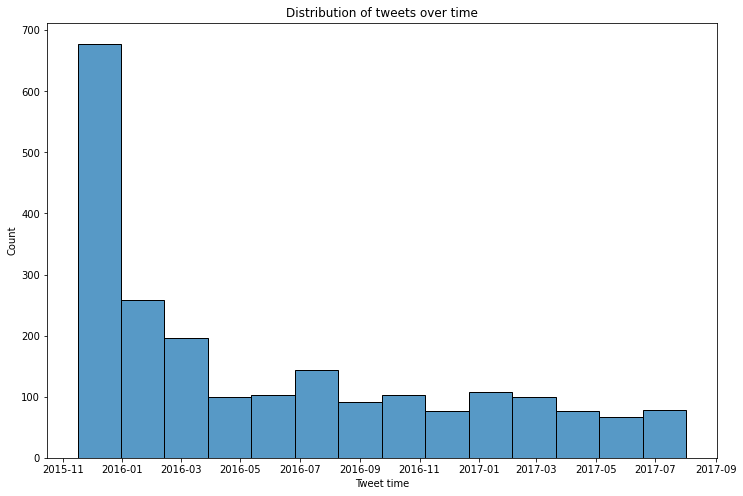

In [108]:
# Plot graph
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.histplot(df["timestamp"])

# Set axis names
ax.set_xlabel("Tweet time")
ax.set_ylabel("Count")

# Set title
ax.set_title("Distribution of tweets over time")

plt.show()

The graph above shows the amount of tweets posted by the account between November 15th, 2015 and August 1st 2017. The distribution is right skewed. This means that more tweets were posted in the early stages of the account. However, it would be wrong to affirm that. It is only correct to say that, in the dataset, more tweets were posted in the early stages of the account. The reality may be different.

### Most common dog breed

In [109]:
df["p1"].value_counts()

golden retriever      139
labrador retriever     95
pembroke               88
chihuahua              79
pug                    54
                     ... 
nail                    1
timber wolf             1
espresso                1
bib                     1
desktop computer        1
Name: p1, Length: 374, dtype: int64

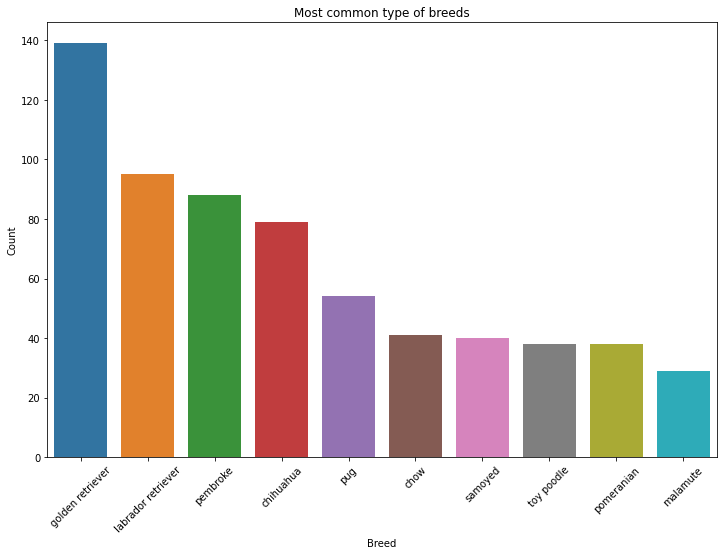

In [115]:
# Define values
breeds = df["p1"].value_counts().index[0:10]
counts = df["p1"].value_counts().values[0:10]

# Plot the graph
fig, ax = plt.subplots(figsize=(12,8))

sns.barplot(x=breeds, y=counts, ax=ax)

# Set axis names
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Breed")
ax.set_ylabel("Count")

# Set graph title
ax.set_title("Most common type of breeds")

plt.show()

The most common dog breed identified by the algorithm was the golden retriever with 150 results. It is follow by the labrador retriever with 100 and the pembroke, also known as corgi, with 89. This result only applies to the 2075 observations catched by the algorithm. Reality may vary.

### Most popular tweet

In [111]:
# Most Retweeted
df.sort_values("retweet_count", ascending=False).tweet_id.head(1)

862    744234799360020481
Name: tweet_id, dtype: int64

In [112]:
# Most Liked
df.sort_values("favorite_count", ascending=False).tweet_id.head(1)

348    822872901745569793
Name: tweet_id, dtype: int64

The tweet with the id "744234799360020481" was the most retweeted one in the dataset. It correspond with the following URL: https://twitter.com/dog_rates/status/744234799360020481.

However, the one with the most likes is the tweet id "822872901745569793". It corresponds with the following URL: https://twitter.com/dog_rates/status/822872901745569793

### Are the most common breeds the most popular tweets?

In [113]:
# Ten most liked tweets
liked = df.sort_values("favorite_count", ascending=False).tweet_id[:10]

# Ten breeds that retrieves the maximum amount of likes
breeds_pop = df[df["tweet_id"].isin(liked)].p1.tolist()

# Ten most common breeds
breeds_common = df["p1"].value_counts().index[0:10].tolist()

# Most liked breeds in most common breeds
for i in breeds_pop:
    if i in breeds_common:
        print(i)

golden retriever
chihuahua
labrador retriever


There are three breeds that raises the most likes and are also very common based on the algorithm. The golden retriever, the chihuahua and the labrador retriever were within the test most common breeds and also within the ten most liked tweets of the dataset.